# ĐỒ ÁN CUỐI KÌ
## Lập trình song song
## Nhóm 07

Lưu Hữu Tình - 21424056

Nguyễn Minh Văn - 21424067

Đỗ Văn Thành - 21424052


## I. Phân tích

Seam carving là một thuật toán dùng để thay đổi kích thước hình ảnh, nó được giới thiệu trong bài báo cáo khoa học của S. Avidan & A. Shamir. Trong bài báo, việc thay đổi kích thước ảnh được thực hiện bằng cách loại bỏ đi các điểm ảnh ít quan trọng và giữ lại các điểm ảnh quan trọng. Bức ảnh dưới đây là minh họa điều này (ảnh bên trên là ảnh gốc với kích thước 332x480 và ảnh bên dưới là ảnh sau khi áp dụng thuật toán seam carving đẻ thu nhỏ còn lại kích thước là 272x400).

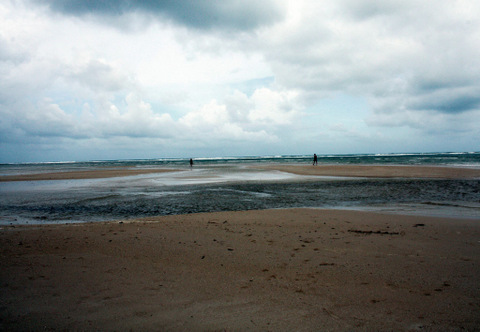

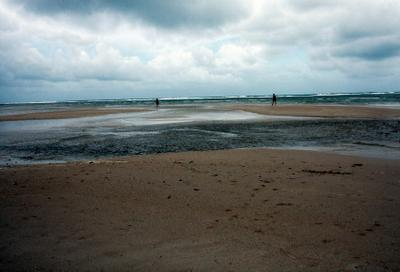

Ý tưởng chính của thuật toán là việc loại bỏ các nội dung có ít ý nghĩa đối với người sử dụng (chứa ít thông tin). Ta gọi thông tin này là độ quan trọng (Energy).

## II. Thiết kế

### 1. Cấu trúc project
main.cu : Nơi bắt đầu chương trình

seam_carving
 + seam_carving.cu : Các function xử lý seam carving
 + seam_carving.cuh : Interface của seam_carving.cu

libraries
 + helper.cu : Các function hỗ trợ
 + helper.cuh : Interface của helper.cu
 + pnm.cu : Các function đọc/ghi file pnm
 + pnm.cuh : Interface của pnm.cuh

images: Chứa ảnh input (pnm)

.result: Chứa kết quả biên dịch main, kết quả output





### 2. Cấu trúc dữ liệu


- Trong 1 bước ảnh, cần tìm ra những điểm pixel có năng lượng thấp và loại bỏ chúng
-> Khó thực hiện được với ảnh RGB -> chúng ta cần chuyển ảnh về Grayscale (xám)

- Trong đó mỗi Pixel đã được lưu dưới dạng _uchar3_ (cấu trúc: x, y, z)

### 3. Cách thực hiện
#### * Mô tả cách thực hiện resize ảnh theo chiều ngang
Các bước chính trong quá trình thực hiện loại bỏ các pixels không quan trọng trên một bức ảnh, các bước dưới đây được thực hiện lặp lại với số lần bằng độ rộng ảnh (input image width) - chiều rộng mong muốn (new width), mỗi lần lặp sẽ xoá một pixel trên mỗi dòng cho toàn bộ các cột của ảnh input

1. Tìm energy map của ảnh input, quá trình tính energy sẽ thực hiện trên toàn bộ các pixels của ảnh input. Và energy chính là mức độ quan trọng của pixel so với các pixels cạnh nó
2. Tính seam path của ảnh input, seam path là các pixel có energy thấp nhất và việc xoá chúng sẽ ít làm ảnh hưởng nhất có thể tới ảnh gốc
3. Xoá các seam path khỏi ảnh input, dịch chuyển các pixel bên phải các pixel bị xoá sang trái một đơn vị để lấp đầy khoảng trống pixel vừa bị xoá và ảnh sẽ giảm đi một pixel bề ngang
4. Lặp lại các bước trên cho tới khi đạt kích thước ảnh mong muốn

#### * Mô tả tính energy map
1. Chuyển ảnh qua grayscale
2. Sử dụng kernal convolution giữa ảnh grayscale và bộ lọc x-sobel và y-sobel
3. Tính energy theo công thức energy = |convolution x-sobel| + |convolution y-sobel|
- Ví dụ qua hình ảnh

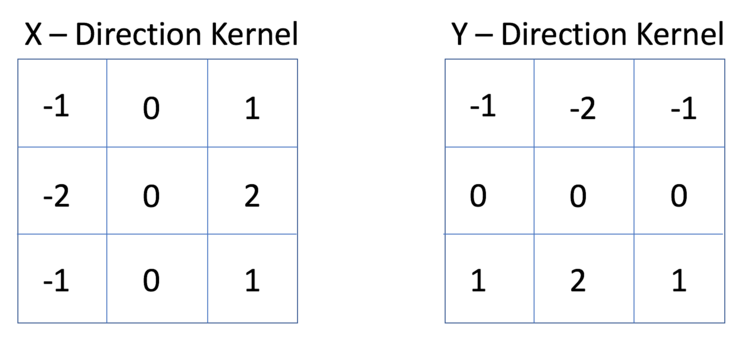

Bằng cách thực hiện convolution theo x-sobel chúng ta có kết quả
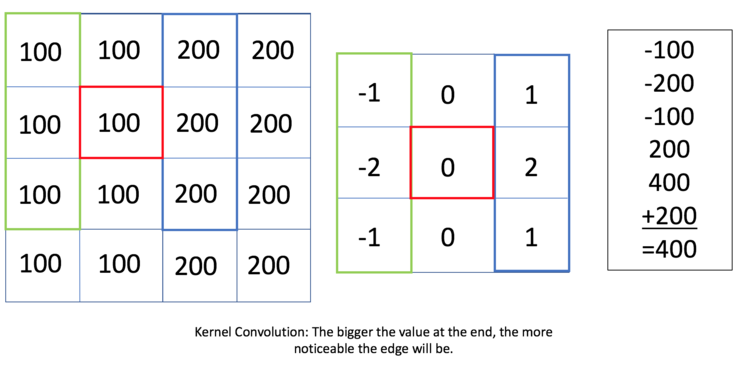
#### * Mô tả cách thực hiện tính seam path
- Quá trình giảm kích thước hình ảnh là việc thực hiện lặp lại việc xoá các pixels đi từ trên xuống dưới có tổng energy thấp nhất (energy map có được từ bước 1 phía trên), và đường đi này gọi là seam path
- Để tìm ra được seam path này, chúng ta sẽ có nhiều phương pháp, và trong đồ án này nhóm sẽ trình bày hai phương pháp chính
##### * Phương pháp tìm seam path từ row đầu tiên tới row cuối cùng
- Bắt đầu từ row đầu tiên của energy map và column đầu tiên, cập nhật seam path với giá trị đầu tiên là giá trị của energy map
- Xuống row tiếp theo tìm energy của 3 pixel bên dưới, chọn energy có giá trị thấp nhất và tiếp tục thực hiện cho tới khi đến row cuối cùng. Ví dụ như hình ảnh này chúng ta có thể tính seam path bắt đầu từ cột thứ 5 dòng 1 (293.9), phía bên dưới có 3 energy và chúng ta chọn energy thấp nhất là 107.89, và tiếp tục như vậy chúng ta có thể tìm ra được đường màu xanh chính là đường seam path cần xoá
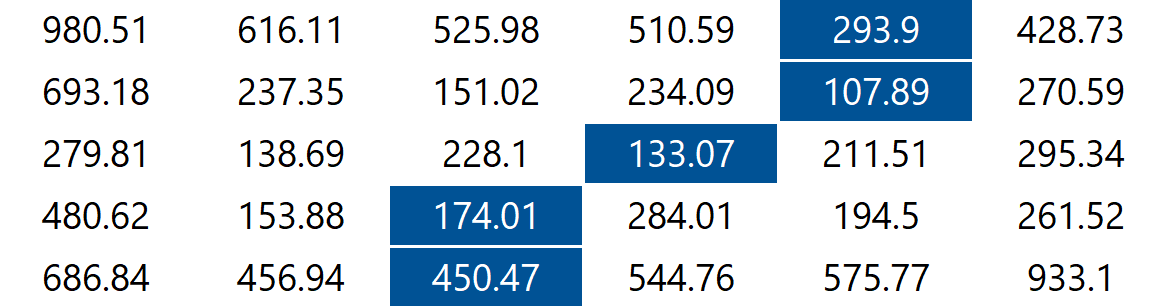


#### * Mô tả xoá seam path
1. Thực hiện xoá các pixel trên seam path trên mỗi dòng, cách làm tuần tự là sử dụng vòng lặp xoá trên từng dòng, cách làm song song là thực hiện xoá pixel trên seam path song song với mỗi thread thực hiện xoá một pixel trên một dòng
2. Cập nhật pixel của ảnh output, với mỗi pixel bị xoá thì các pixel ở các cột có giá trị lớn hơn cột vừa xoá dịch pixel sang trái một đơn vị

- Vấn đề performance cần cân nhắc
  - Mỗi lần chúng ta thực hiện xoá seam path thì cần phải cập nhật lại energy map, việc này cần phải quét lại toàn bộ các pixel trên ảnh đang xử lý
  - Giải pháp: Vì mỗi dòng chỉ có 1 pixel duy nhất bị xoá, nên ngoài các pixel lân cận pixel vừa bị xoá sẽ bị thay đổi energy, các pixel không lân cận không ảnh hưởng nên chúng ta chỉ cần cập nhật lại energy cho các pixel cạnh pixel vừa bị xoá, không cần thực hiện lại việc tính energy trên toàn bộ ảnh


### 4. Các phần song song hóa
1. Song song hoá tìm energy map
  - Mỗi thread sẽ xử lý từng Pixel, đọc ghi dữ liệu từ GMEM
  - Các pixel lân cận được đưa vào shared memory để truy nhanh chóng truy xuất thay vì sử dụng global input image pixel để tính energy
2. Tìm minimum energy map
  - Mỗi thread sẽ tính minimum energy trên một column thay vì thực hiện hai vòng lặp trên dòng và cột của energy map
3. Xoá seam path
  - Thực hiện xoá seam path song song, mỗi thread thực hiện xoá một pixel trên một dòng và thực hiện dịch các pixel bên phải của pixel vừa bị xoá về trái một pixel để lấp đầy khoảng trống pixel vừa xoá


### 5. Cách để tối ưu hóa

##### * Phương pháp tìm minimal energy map từ dưới lên
- Minimal Energy map lúc này là sẽ chứa giá trị minimal energy từ một vị trí trên ma trận tới đáy thay vì chứa energy map
- Copy toàn bộ dòng cuối cùng của energy map sang minimal energy map vì dòng cuối cùng của energy map cũng chính là energy tối thiểu khi ở row cuối của ảnh
- Tiếp tục xử lý ô ngay bên trên của ô vừa chọn, lấy giá trị của ô bên trên + giá trị nhỏ nhất của các ô ngay bên dưới lân cận 
- Lặp lại các bước này cho tới dòng đầu tiên
- Lặp lại toàn bộ các bước cho các cột tiếp theo từ dưới đi lên
- Thu được minimal energy map
Sau khi tìm được minimal energy map chúng ta sẽ có seam path bắt đầu từ dòng đầu tiên tại cột có giá trị nhỏ nhất

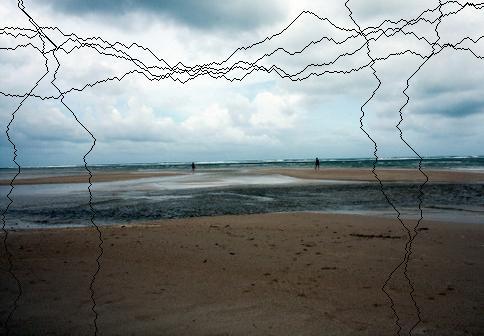

## III. Cài đặt

### 1. Hàm hỗ trợ show ảnh

In [ ]:
from PIL import Image
import numpy as np
def show_pnm(file_name):
    with open(file_name, 'r') as f:
        vals = f.read().split()
        w = int(vals[1])
        h = int(vals[2])
        if vals[0] == 'P2': # Grayscale
            pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
        elif vals[0] == 'P3': # RGB
            pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
        else:
            return None

    return Image.fromarray(pixels)

def show_matrix(matrix_file):
    '''
    input: filename
    output: show matrix

    Each element on the same line is sperated by a space
    '''
    m = np.loadtxt(matrix_file)
    m = m + m.min()
    m = m / m.max()
    m = m * 255
    m = m.astype(np.uint8)
    return Image.fromarray(m)

### 1. Lấy source từ git

In [31]:
!git clone https://github.com/huutinhluu/DACK_LTSS.git

%cd ./DACK_LTSS/

Cloning into 'DACK_LTSS'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 51 (delta 12), reused 40 (delta 9), pack-reused 0
Unpacking objects: 100% (51/51), 2.84 MiB | 5.24 MiB/s, done.
/content/DACK_LTSS/.result/DACK_LTSS/DACK_LTSS/.result/DACK_LTSS/.result/DACK_LTSS


Chú thích
- Câu lệnh dưới là câu lệnh biên dịch chương trình và không được chỉnh sửa giá trị

In [32]:
!nvcc main.cu seam_carving/seam_carving.cu libraries/helper.cu libraries/pnm.cu -o .result/seam_carving

seam_carving/seam_carving.cu(213): warning #177-D: variable "halfBlock" was declared but never referenced



In [33]:
%cd .result

/content/DACK_LTSS/.result/DACK_LTSS/DACK_LTSS/.result/DACK_LTSS/.result/DACK_LTSS/.result


Chú thích
- ./seam_carving: tên chương trình thực thi
- arg[0] (../images/in1.pnm): đường dẫn tới ảnh gốc
- arg[1] (images/out1.pnm): đường dẫn tới ảnh sau khi resize
- arg[2] (100): chiều ngang của ảnh sau khi resize (phải nhỏ hơn chiều ngang của ảnh gốc)

In [34]:
!./seam_carving ../images/in1.pnm images/out.pnm 100

Image size (width x height): 274 x 186

_____________GPU info_____________
|Name:                   Tesla T4|
|Compute capability:          7.5|
|Num SMs:                      40|
|Max num threads per SM:     1024|
|Max num warps per SM:         32|
|GMEM:           15835398144 byte|
|SMEM per SM:          65536 byte|
|SMEM per block:       49152 byte|
|________________________________|
Processing time of host: 177.829697 ms

Processing time of device: 76.317856 ms

Processing time of device (optimized version): 42.524448 ms

Error between device result and host result: : 0.000000


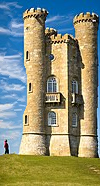

In [ ]:
show_pnm('./images/out.pnm_device1.pnm')

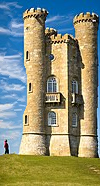

In [ ]:
show_pnm('./images/out.pnm_device2.pnm')

## IV. Đánh giá
+ Khó khăn:
  - Thuật toán khó hiểu mất nhiều thời gian để tìm hiểu
  - Gặp nhiều vấn đề trong quá trình debug và kiểm tra trương trình có hoạt động đúng hay không
  - Lập trình song song chứa nhiều khái niệm trừu tượng nên khó nắm bắt được hết trong quá trình học và làm đồ án
  - Cần tham khảo rất nhiều nguồn khác nhau trên mạng để tìm được cách cài đơn giản nhất
+ Hiệu quả
  - Có thể hoàn thành chương trình resize ảnh trên host và device
  - Kiểm tra được tốc độ thực hiện trên device là nhanh hơn rất nhiều so với trên host
  - Hiểu được các trường hợp cần sử dụng lập trình song song để tối ưu các chương trình
+ Cần cải thiện:
  - Cần phải lập trình nhiều hơn để thành thạo hơn việc xử lý song song
  - Cần tìm hiểu các kịch bản khác của thuật toán một cách cụ thể hơn (tính energy map, minimumn energy map, cách tính từ trên xuống, cách tính vét cạn, cách tính từ dưới lên...)



Tham khảo:

https://vnoi.info/wiki/cs/imageprocessing/Seam-Carving.md

https://www.youtube.com/watch?v=rpB6zQNsbQU&t=972s